In [89]:
!pip install pandas
!pip install openpyxl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import ElasticNet
from sklearn.metrics import accuracy_score, brier_score_loss, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, f1_score
from catboost import CatBoostClassifier

In [90]:
file_path = '/Users/sandeepreddymodugu/Downloads/Cleaned_Data.xlsx'

cleaned_data = pd.read_excel(file_path)

In [91]:
cleaned_data.head()

,Job Title,Job Function,Job Category,Compa Ratio,Pay Level,Work Location,Work Country,Gender,Employee Status,Termination Date,Tenure,Generation,Termination Type,Termination Reason,Cost to Replace Employee Multiplier,Base Pay Mid Point Annualized USD
0,Principal Engineer,Engineering,Engineering Professional,0.675,P6,Cupertino United States,United States,M,Terminated,2017-09-25,32.194521,Boomer,Involuntary Termination,Position Elimination / RIF Involuntary,1.25,270004.8
1,Managing Principal Engineer,Engineering,Management,0.979,M4,Fremont United States,United States,M,Terminated,2022-02-04,31.079452,Boomer,Voluntary Termination,Compensation/Pay,1.25,203008.0
2,Staff Engineer,Engineering,Engineering Professional,1.146,P4,Remote US,United States,M,Active,NaT,33.101370,Boomer,Not Terminated,Active Employee / Not Terminated,1.25,118996.8
3,Sr Staff Program/Project Manager,Information Technology,Professional,0.941,P5,Fremont United States,United States,F,Active,NaT,32.969863,Gen X,Not Terminated,Active Employee / Not Terminated,1.25,184995.2
4,Technologist,Engineering,Engineering Professional,0.932,P7,Longmont United States,United States,M,Active,NaT,32.947945,Boomer,Not Terminated,Active Employee / Not Terminated,1.25,249995.2


In [92]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25856 entries, 0 to 25855
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Job Title                            25856 non-null  object        
 1   Job Function                         25856 non-null  object        
 2   Job Category                         25856 non-null  object        
 3   Compa Ratio                          25856 non-null  float64       
 4   Pay Level                            25856 non-null  object        
 5   Work Location                        25856 non-null  object        
 6   Work Country                         25856 non-null  object        
 7   Gender                               25856 non-null  object        
 8   Employee Status                      25856 non-null  object        
 9   Termination Date                     14188 non-null  datetime64[ns]
 10  Tenure    

In [93]:
# Convert 'Termination Date' to datetime if it's not
cleaned_data['Termination Date'] = pd.to_datetime(cleaned_data['Termination Date'])

In [94]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25856 entries, 0 to 25855
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Job Title                            25856 non-null  object        
 1   Job Function                         25856 non-null  object        
 2   Job Category                         25856 non-null  object        
 3   Compa Ratio                          25856 non-null  float64       
 4   Pay Level                            25856 non-null  object        
 5   Work Location                        25856 non-null  object        
 6   Work Country                         25856 non-null  object        
 7   Gender                               25856 non-null  object        
 8   Employee Status                      25856 non-null  object        
 9   Termination Date                     14188 non-null  datetime64[ns]
 10  Tenure    

In [95]:
terminated_employees = cleaned_data[cleaned_data['Termination Date'].notna()].copy()

active_employees = cleaned_data[cleaned_data['Termination Date'].isnull()].copy()

In [96]:
# Creating a binary target variable for voluntary termination
terminated_employees['Is Voluntary'] = (terminated_employees['Termination Type'] == 'Voluntary Termination').astype(int)

In [97]:
terminated_employees['Termination Type'].value_counts()

Termination Type
Involuntary Termination    6834
Voluntary Termination      6432
Other Termination           761
Release Termination         161
Name: count, dtype: int64

In [98]:
terminated_employees['Is Voluntary'].value_counts()

Is Voluntary
0    7756
1    6432
Name: count, dtype: int64

In [99]:
active_employees['Termination Type'].value_counts()

Termination Type
Not Terminated    11668
Name: count, dtype: int64

In [100]:
categorical_features = [
    'Job Title', 'Job Function', 'Job Category', 'Pay Level', 'Work Location',
    'Work Country', 'Gender', 'Employee Status', 'Generation'
]
numerical_features = ['Compa Ratio', 'Tenure', 'Cost to Replace Employee Multiplier', 'Base Pay Mid Point Annualized USD']

In [101]:
# Prepare the feature matrix X and the target vector y as before
X = terminated_employees[categorical_features + numerical_features].copy()
y = terminated_employees['Is Voluntary']

# Convert categorical data to numerical using one-hot encoding for correlation analysis
X_encoded = pd.get_dummies(X, columns=categorical_features)

# Add target variable to the DataFrame for correlation computation
X_encoded['Is Voluntary'] = y

# Calculate correlation matrix
correlation_matrix = X_encoded.corr()

# Extract correlations of features with the target variable
target_correlation = correlation_matrix['Is Voluntary'].drop('Is Voluntary')  # drop self-correlation

# Display features with high correlation with the target
high_correlation_features = target_correlation[np.abs(target_correlation) > 0.5].sort_values(ascending=False)
print("Features highly correlated with the target:\n", high_correlation_features)

Features highly correlated with the target:
 Series([], Name: Is Voluntary, dtype: float64)


CatBoost Accuracy: 0.7766032417195208


/Users/sandeepreddymodugu/anaconda3/lib/python3.10/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Brier Score on training after calibration: 0.1289263516912059


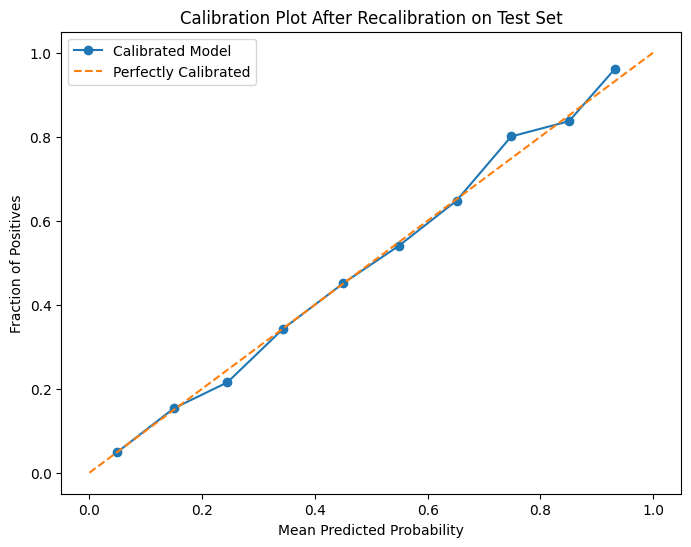

Brier Score on test after calibration: 0.15018003636740643


In [102]:
# ... your existing setup for categorical and numerical features ...

# Assuming cleaned_data is loaded and terminated_employees is defined
X = terminated_employees[categorical_features + numerical_features].copy()
y = terminated_employees['Is Voluntary']

# One-hot encode categorical variables
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ], remainder='passthrough')

# Initialize the CatBoostClassifier
model_2 = CatBoostClassifier(iterations=100, random_seed=0, verbose=False)

# Create the full pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model_2)])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Train the model
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f'CatBoost Accuracy: {accuracy}')

# Preprocess the training data
X_train_preprocessed = pipeline.named_steps['preprocessor'].transform(X_train)

# Define a stratified k-fold cross-validator for the calibration
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Calibrate the model on the preprocessed training data using cross-validation
calibrated = CalibratedClassifierCV(base_estimator=pipeline.named_steps['model'], cv=cv, method='isotonic')
calibrated.fit(X_train_preprocessed, y_train)

# Get the calibrated probabilities on the training set
calibrated_probabilities_train = calibrated.predict_proba(X_train_preprocessed)[:, 1]

# Brier score after calibration on the training set
brier_train = brier_score_loss(y_train, calibrated_probabilities_train)
print(f"Brier Score on training after calibration: {brier_train}")

# Use the calibrated model on the test set
X_test_preprocessed = pipeline.named_steps['preprocessor'].transform(X_test)
calibrated_probabilities_test = calibrated.predict_proba(X_test_preprocessed)[:, 1]

# Create calibration curves for the test set
true_probas_test, pred_probas_test = calibration_curve(y_test, calibrated_probabilities_test, n_bins=10)
plt.figure(figsize=(8, 6))
plt.plot(pred_probas_test, true_probas_test, marker='o', linestyle='-', label='Calibrated Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plot After Recalibration on Test Set')
plt.legend()
plt.show()

# Brier score after calibration on the test set
brier_test = brier_score_loss(y_test, calibrated_probabilities_test)
print(f"Brier Score on test after calibration: {brier_test}")

In [103]:
# Detailed classification report
print(classification_report(y_test, y_pred))

# ROC-AUC score
calibrated_probabilities_test = calibrated.predict_proba(X_test_preprocessed)[:, 1]

# Now you can calculate the ROC-AUC score using these probabilities
roc_auc = roc_auc_score(y_test, calibrated_probabilities_test)
print(f'ROC-AUC Score: {roc_auc}')

              precision    recall  f1-score   support

           0       0.80      0.78      0.79      1542
           1       0.75      0.77      0.76      1296

    accuracy                           0.78      2838
   macro avg       0.77      0.78      0.78      2838
weighted avg       0.78      0.78      0.78      2838

ROC-AUC Score: 0.863042625418328


In [104]:
# Prepare active employees features for prediction, excluding 'Estimated Start Date'
X_active = active_employees[categorical_features + numerical_features].copy()

# Transform the active employee data using the preprocessor from the calibrated pipeline
X_active_preprocessed = preprocessor.transform(X_active)

# Use the calibrated model to predict the active employees' probabilities
active_employees['Voluntary Termination Probability'] = calibrated.predict_proba(X_active_preprocessed)[:, 1]

# Sort and examine the highest risk employees
active_employees_sorted = active_employees.sort_values(by='Voluntary Termination Probability', ascending=False)
top_risk_employees = active_employees_sorted.head(10)

print("Top risk employees:")
print(top_risk_employees)

Top risk employees:
           Job Title        Job Function  Job Category  Compa Ratio Pay Level  \
22693  Accountant II  Finance/Accounting  Professional        0.741        P2   
22764  Accountant II  Finance/Accounting  Professional        0.755        P2   
22769  Accountant II  Finance/Accounting  Professional        0.741        P2   
25689     Sr Analyst  Finance/Accounting  Professional        0.800        P3   
22692   Accountant I  Finance/Accounting  Professional        0.728        P1   
22699  Accountant II  Finance/Accounting  Professional        0.741        P2   
20700     Analyst II  Finance/Accounting  Professional        0.753        P2   
22589     Analyst II  Finance/Accounting  Professional        0.816        P2   
25606      Analyst I  Finance/Accounting  Professional        0.728        P1   
24656     Analyst II  Finance/Accounting  Professional        0.778        P2   

          Work Location Work Country Gender Employee Status Termination Date  \
22693  T

Optimal threshold based on F1 score: 0.42139862938172606
Maximum F1 score: 0.7758312477654631


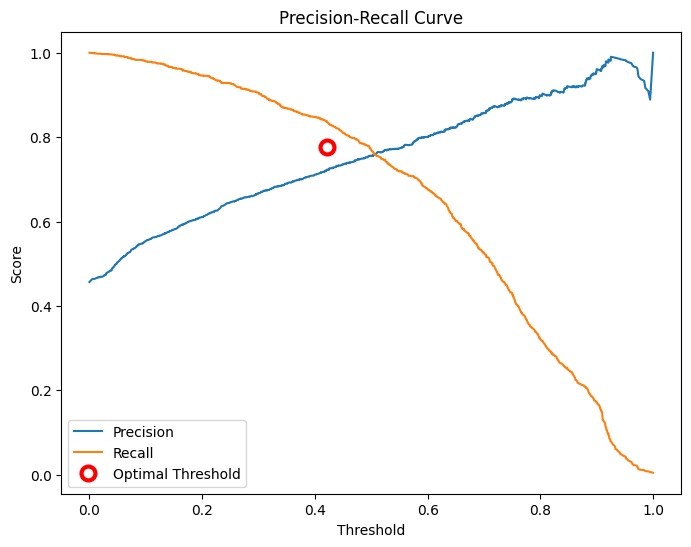

In [105]:
# Use the probabilities you've got from the calibrated model
y_probs = calibrated.predict_proba(X_test_preprocessed)[:, 1]

# Calculate precision and recall for various thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Calculate the F1 score for each threshold
f1_scores = 2 * recall * precision / (recall + precision)

# Find the index of the highest F1 score
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_f1_score = f1_scores[optimal_idx]

print(f"Optimal threshold based on F1 score: {optimal_threshold}")
print(f"Maximum F1 score: {optimal_f1_score}")

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(optimal_threshold, optimal_f1_score, 'o', markersize=10, label='Optimal Threshold', fillstyle="none", c='r', mew=3)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [106]:
# Set a threshold for high risk of voluntary termination
threshold = 0.421 # Adjust this threshold as needed

# Flag high-risk employees based on the threshold
active_employees['High Risk'] = (active_employees['Voluntary Termination Probability'] >= threshold).astype(int)

# Now, you can calculate the number of high-risk employees
high_risk_count = active_employees['High Risk'].sum()

# Calculate the number of employees predicted to leave each year based on historical trends
termination_distribution = {
    1: 0.15,  # 20% leave within the first year but we're calculating for 3 quarters
    2: 0.15,  # 15% leave in the second year
    3: 0.11,  # and so on...
    4: 0.08,
    5: 0.13,
    6: 0.16,
    '6+': 0.22  # Assuming that after the sixth year, the likelihood is spread over many years
}

# The total count of high-risk employees from your prediction model
high_risk_count = active_employees['High Risk'].sum()

# Estimated terminations per year based on the distribution
estimated_terminations_per_year = {year: int(high_risk_count * percent) for year, percent in termination_distribution.items()}

# Display the estimated terminations per year
print("Estimated terminations per year based on historical distribution:")
for year, count in estimated_terminations_per_year.items():
    print(f"Year {year}: {count}")

Estimated terminations per year based on historical distribution:
Year 1: 808
Year 2: 808
Year 3: 592
Year 4: 431
Year 5: 700
Year 6: 862
Year 6+: 1185


In [107]:
import numpy as np

# First, calculate total high-risk employees
total_high_risk = (active_employees['Voluntary Termination Probability'] >= threshold).sum()

# Calculate the exact number of employees for each termination year
terminations_per_year = {year: int(total_high_risk * percent) for year, percent in termination_distribution.items()}

# Initialize the column for estimated termination year
active_employees['Estimated Termination Year'] = None

# A list to hold indices already assigned to avoid duplicates
assigned_indices = []

# For each year, assign the calculated number of terminations
for year, count in terminations_per_year.items():
    # Get random sample of indices from high-risk employees not yet assigned a year
    available_indices = active_employees[(active_employees['Voluntary Termination Probability'] >= threshold) & (active_employees.index.isin(assigned_indices) == False)].index
    chosen_indices = np.random.choice(available_indices, size=count, replace=False)
    active_employees.loc[chosen_indices, 'Estimated Termination Year'] = f"Year {year}"
    assigned_indices.extend(chosen_indices)

# Display the count of estimated terminations per year
print(active_employees['Estimated Termination Year'].value_counts())

Estimated Termination Year
Year 6+    1185
Year 6      862
Year 1      808
Year 2      808
Year 5      700
Year 3      592
Year 4      431
Name: count, dtype: int64


In [108]:
active_employees

,Job Title,Job Function,Job Category,Compa Ratio,Pay Level,Work Location,Work Country,Gender,Employee Status,Termination Date,Tenure,Generation,Termination Type,Termination Reason,Cost to Replace Employee Multiplier,Base Pay Mid Point Annualized USD,Voluntary Termination Probability,High Risk,Estimated Termination Year
2,Staff Engineer,Engineering,Engineering Professional,1.146,P4,Remote US,United States,M,Active,NaT,33.101370,Boomer,Not Terminated,Active Employee / Not Terminated,1.25,118996.8,0.033512,0,None
3,Sr Staff Program/Project Manager,Information Technology,Professional,0.941,P5,Fremont United States,United States,F,Active,NaT,32.969863,Gen X,Not Terminated,Active Employee / Not Terminated,1.25,184995.2,0.127892,0,None
4,Technologist,Engineering,Engineering Professional,0.932,P7,Longmont United States,United States,M,Active,NaT,32.947945,Boomer,Not Terminated,Active Employee / Not Terminated,1.25,249995.2,0.068815,0,None
7,Sr Engineering Specialist,Engineering Services,Operations Support,1.079,S5,Fremont United States,United States,M,Active,NaT,33.115068,Gen X,Not Terminated,Active Employee / Not Terminated,0.50,100006.4,0.030565,0,None
11,Principal Engineer,Engineering,Engineering Professional,0.924,P6,Remote US,United States,M,Active,NaT,21.093151,Boomer,Not Terminated,Active Employee / Not Terminated,1.25,206003.2,0.058240,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25830,Engineering Specialist IV,Quality,Operations Support,0.892,S4,Fremont United States,United States,F,Active,NaT,36.295890,Boomer,Not Terminated,Active Employee / Not Terminated,0.50,80995.2,0.052719,0,None
25831,Sr Staff Engineer,Engineering,Engineering Professional,1.003,P5,Shakopee United States,United States,M,Active,NaT,30.663014,Boomer,Not Terminated,Active Employee / Not Terminated,1.25,167003.2,0.036225,0,None
25842,Engineering Specialist IV,Engineering Services,Operations Support,0.976,S4,Fremont United States,United States,M,Active,NaT,33.690411,Boomer,Not Terminated,Active Employee / Not Terminated,0.50,89003.2,0.044234,0,None
25849,Sr Staff Engineer,Engineering,Engineering Professional,0.954,P5,Longmont United States,United States,M,Active,NaT,30.509589,Boomer,Not Terminated,Active Employee / Not Terminated,1.25,182000.0,0.061527,0,None


In [110]:
# Assuming 'active_employees' DataFrame is ready
output_file_path = '/Users/sandeepreddymodugu/Downloads/Active_Employees_Final.xlsx'

# Export the DataFrame to an Excel file
active_employees.to_excel(output_file_path, index=False, engine='openpyxl')

In [111]:
# Perform the group by operation and calculate the count and average tenure
grouped_data = active_employees.groupby(['Estimated Termination Year', 'Gender', 'Work Country', 'Job Category']) \
                               .agg(Count=('Estimated Termination Year', 'size'),
                                    Average_Tenure=('Tenure', 'mean')) \
                               .reset_index()

# Export the grouped data to an Excel file
output_file_path = 'Grouped_Active_Employees.xlsx'
grouped_data.to_excel(output_file_path, index=False, engine='openpyxl')

print("Data exported successfully to", output_file_path)

Data exported successfully to Grouped_Active_Employees.xlsx
